### Polynomial Chaos Expansion example: Sphere function (2 random inputs, scalar output)

Author: Katiana Kontolati \
Date: December 8, 2020

In this example, PCE is used to generate a surrogate model for a given set of 2D data.

### Sphere function

<img src="Example_Sphere_function.png" alt="Drawing" style="width: 400px;"/>

$$ f(\textbf{x}) = x_1^2 + x_2^2$$

**Description:**  Dimensions: 2

**Input Domain:**  This function is evaluated on the hypercube $x_i \in [-5.12, 5.12]$ for all i = 1,2.

**Global minimum:** $f(x^*)=0,$ at $x^* = (0,0)$.

**Reference:**  Dixon, L. C. W., & Szego, G. P. (1978). The global optimization problem: an introduction. Towards global optimization, 2, 1-15.

Import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from UQpy.Surrogates import *
from UQpy.Distributions import Uniform, JointInd

Define the function.

In [2]:
def function(x,y):
    return x**2 + y**2

Create a distribution object, generate samples and evaluate the function at the samples.

In [3]:
np.random.seed(1)

dist_1 = Uniform(loc=-5.12, scale=10.24)   
dist_2 = Uniform(loc=-5.12, scale=10.24)    

marg = [dist_1, dist_2]
joint = JointInd(marginals=marg)

n_samples = 100
x = joint.rvs(n_samples)
y = function(x[:,0], x[:,1])  

Visualize the 2D function.

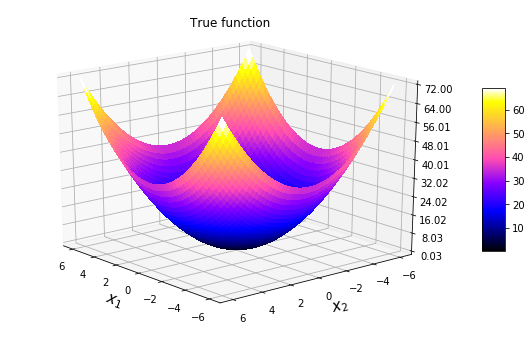

In [4]:
xmin, xmax = -6,6
ymin, ymax = -6,6
X1 = np.linspace(xmin, xmax, 50)
X2 = np.linspace(ymin, ymax, 50)
X1_, X2_ = np.meshgrid(X1, X2) # grid of points
f = function(X1_, X2_)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1_, X2_, f, rstride=1, cstride=1, cmap='gnuplot2', linewidth=0, antialiased=False)
ax.set_title('True function')
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20, 140)
fig.colorbar(surf, shrink=0.5, aspect=7)

plt.show()

Visualize training data.

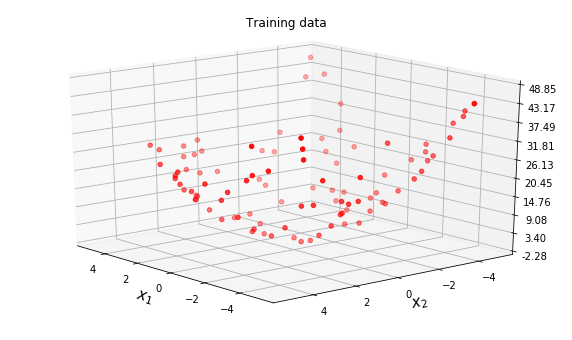

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], y, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,140)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_xlim(-10,10)
#ax.set_ylim(-6,6)
#ax.set_zlim(-1,1.5)
plt.show()

Create an object from the PCE class.

In [9]:
max_degree = 3
pce = PolyChaosExp(joint) 
construct_td_basis(pce, max_degree)

Compute PCE coefficients using least squares regression.

In [10]:
fit_lstsq(pce, x, y)

Compute PCE coefficients using LASSO.

In [12]:
pce2 = PolyChaosExp(joint)  
construct_td_basis(pce2, max_degree)
fit_lasso(pce2, x, y) 

Compute PCE coefficients with Ridge regression.

In [13]:
pce3 = PolyChaosExp(joint)  
construct_td_basis(pce3, max_degree)
fit_ridge(pce3, x, y) 

PCE surrogate is used to predict the behavior of the function at new samples.

In [14]:
n_test_samples = 10000
x_test = joint.rvs(n_test_samples)
y_test = pce.predict(x_test)

Plot PCE prediction.

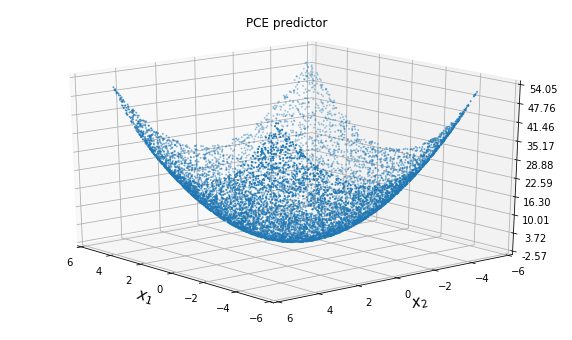

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], y_test, s=1)

ax.set_title('PCE predictor')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,140)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_zlim(0,136)
plt.show()

### Error Estimation

Validation error.

In [16]:
# validation sample
n_samples = 150
x_val = joint.rvs(n_samples)
y_val = function(x_val[:,0], x_val[:,1])

# PCE predictions
y_pce  = pce.predict(x_val).flatten()
y_pce2 = pce2.predict(x_val).flatten()
y_pce3 = pce3.predict(x_val).flatten()

# mean relative validation errors
error = np.sum(np.abs((y_val - y_pce)/y_val))/n_samples
error2 = np.sum(np.abs((y_val - y_pce2)/y_val))/n_samples
error3 = np.sum(np.abs((y_val - y_pce3)/y_val))/n_samples

print('Mean rel. error, LSTSQ:', error)
print('Mean rel. error, LASSO:', error2)
print('Mean rel. error, Ridge:', error3)

Mean rel. error, LSTSQ: 4.508769282935154e-15
Mean rel. error, LASSO: 0.0010814080466502762
Mean rel. error, Ridge: 0.022999347585135183


### Moment Estimation

Returns mean and variance of the PCE surrogate.

In [18]:
n_mc = 1000000
x_mc = joint.rvs(n_mc)
y_mc = function(x_mc[:,0], x_mc[:,1])    
mean_mc = np.mean(y_mc)
var_mc = np.var(y_mc)

print('Moments from least squares regression :', pce_mean(pce), pce_variance(pce))
print('Moments from LASSO regression :', pce_mean(pce2), pce_variance(pce2))
print('Moments from Ridge regression :', pce_mean(pce3), pce_variance(pce3))
print('Moments from Monte Carlo integration: ', mean_mc, var_mc)

Moments from least squares regression : [17.47626667] [122.16795864]
Moments from LASSO regression : [17.47503399] [122.01572481]
Moments from Ridge regression : [17.44278393] [118.8751701]
Moments from Monte Carlo integration:  17.48583010443435 122.15231564349098
